In [1]:
import feather
import scipy as sp
import numpy as np
import pandas as pd
import lightgbm as lgb

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

def get_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def get_y():
    return pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv', usecols=[target]).values.flatten()
    
def run_model(X_train, y_train, X_valid, y_valid,
            categorical_features, numerical_features,
            predictors, maxvalue_dict, fold_id):
    train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    valid = lgb.Dataset(X_valid, y_valid, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    evals_result = {}
    model = lgb.train(
        MODEL_PARAMS,
        train,
        valid_sets=[valid],
        valid_names=['valid'],
        evals_result=evals_result,
        **FIT_PARAMS
    )
    
    # validation score
    y_pred_valid = model.predict(X_valid)

    # feature importances
    importances = pd.DataFrame()
    importances['feature'] = predictors
    importances['gain'] = model.feature_importance(importance_type='gain')
    importances['split'] = model.feature_importance(importance_type='split')
    importances['fold'] = fold_id

    return y_pred_valid, importances
 
def plot_mean_feature_importances(feature_importances, max_num=50, importance_type='gain', path=None):
    mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean()
    feature_importances['mean_' + importance_type] = feature_importances['feature'].map(mean_gain[importance_type])

    if path is not None:
        data = feature_importances.sort_values('mean_'+importance_type, ascending=False).iloc[:max_num, :]
        plt.clf()
        plt.figure(figsize=(16, 8))
        sns.barplot(x=importance_type, y='feature', data=data)
        plt.tight_layout()
        plt.savefig(path)
    
    return feature_importances

def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [117]:
target = 'AdoptionSpeed'
len_train = 14993
len_test = 3948
    
    
# ===============
# Params
# ===============
seed = 777
n_splits = 5
np.random.seed(seed)

# feature engineering
n_components = 5
img_size = 256
batch_size = 256

# model
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9,
    'max_bin': 127,
    'reg_alpha': 0.11,
    'reg_lambda': 0.01,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 10,
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}
FIT_PARAMS = {
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'verbose_eval': 10000,
}

# define
maxvalue_dict = {}
categorical_features = [
     'Breed1',
     'Breed2',
     'Color1',
     'Color2',
     'Color3',
     'Dewormed',
     'FurLength',
     'Gender',
     'Health',
     'MaturitySize',
     'State',
     'Sterilized',
     'Type',
     'Vaccinated',
     'Type_main_breed',
     'BreedName_main_breed',
     'Type_second_breed',
     'BreedName_second_breed',
]
numerical_features = []
text_features = ['Name', 'Description']
remove = ['index', 'seq_text', 'PetID', 'Name', 'Description', 'RescuerID', 'StateName', 'annots_top_desc']

In [118]:
elmo3072_heavy_mag.feather
elmo3072_light_mag.feather
glove_lem_light_mag.feather

NameError: name 'elmo3072_heavy_mag' is not defined

In [124]:
train = feather.read_dataframe('X_train460.feather')
n_train = len(train)

#0.4531443069887183
#df_ = feather.read_dataframe("feature/glove_meta_fix.feather")
#train = pd.concat((train, df_[:n_train]), axis=1)

"""
#0.4536310090953328
df_ = feather.read_dataframe("feature/glove_wiki_light_mag.feather")
train = pd.concat((train, df_[:n_train]), axis=1)"""

'\n#0.4536310090953328\ndf_ = feather.read_dataframe("feature/glove_wiki_light_mag.feather")\ntrain = pd.concat((train, df_[:n_train]), axis=1)'

In [125]:
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31, #no 15
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9, #no 7
    'max_bin': 127, #no63, 255
    'reg_alpha': 0.5, #no 1.0
    'reg_lambda': 0.01, #no0.5
    'min_child_weight': 0.2, #no impact
    'min_child_samples': 10, #no 5
    'min_gain_to_split': 0.02,#no0.1, 0.01
    'min_data_in_bin': 3, #no10
    'bin_construct_sample_cnt': 5000, #no 3000, 7000
    'cat_l2': 10, #no
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[600]	valid's rmse: 1.03027
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1463]	valid's rmse: 1.04677
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[608]	valid's rmse: 1.03924
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1005]	valid's rmse: 1.04343
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[925]	valid's rmse: 1.0547
0.44829716965133637
CPU times: user 1h 23min 4s, sys: 22.8 s, total: 1h 23min 27s
Wall time: 5min 46s


<Figure size 432x288 with 0 Axes>

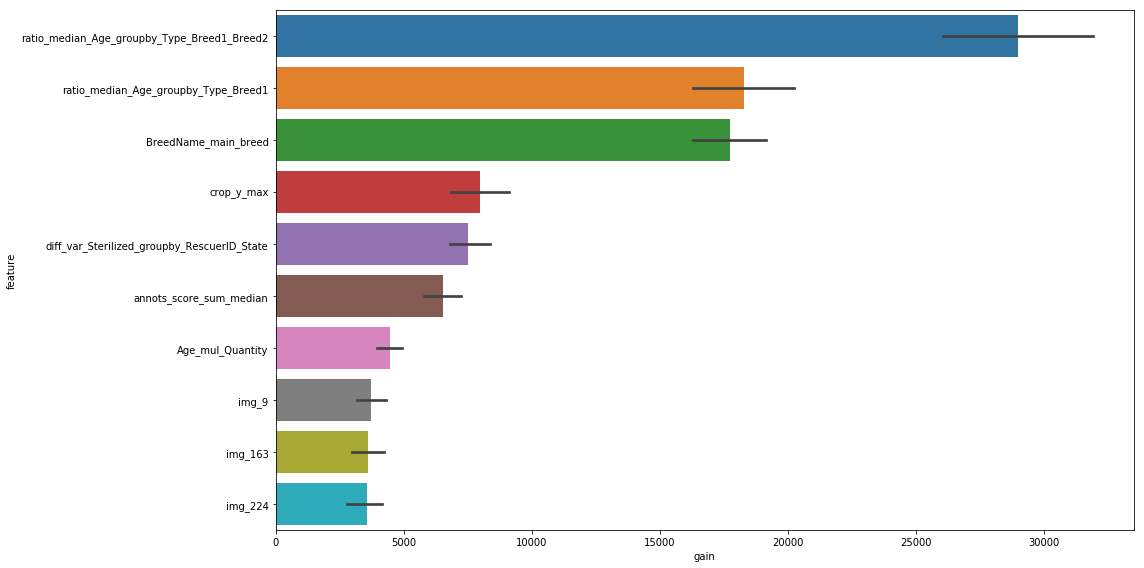

In [131]:
%%time
categorical_features = list(set(categorical_features) - set(remove))
numerical_features = list(set(train.columns) - set(categorical_features + [target] + remove))
predictors = categorical_features + numerical_features
train = train.loc[:, ~train.columns.duplicated()]

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
cv = GroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

In [113]:
0.449078003109212
0.4578382416570741

0.4578382416570741

In [25]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y, y_pred_opt))

,0,1,2,3,4
0,16,156,149,34,55
1,78,1118,1375,264,255
2,41,1098,1763,539,596
3,26,699,1415,485,634
4,3,194,1043,712,2245


In [ ]:
0.489964545495568

In [127]:
importance_type="gain"
mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean().reset_index()
data = mean_gain.sort_values(importance_type, ascending=False)
print(len(data))
data.head()

3784


,feature,gain
3560,ratio_median_Age_groupby_Type_Breed1_Breed2,28993.995319
3559,ratio_median_Age_groupby_Type_Breed1,18273.497004
12,BreedName_main_breed,17874.559747
2119,crop_y_max,7964.309115
2339,diff_var_Sterilized_groupby_RescuerID_State,7543.235582


In [137]:
list(data.feature[:150].values)

['ratio_median_Age_groupby_Type_Breed1_Breed2',
 'ratio_median_Age_groupby_Type_Breed1',
 'BreedName_main_breed',
 'crop_y_max',
 'diff_var_Sterilized_groupby_RescuerID_State',
 'annots_score_sum_median',
 'Age_mul_Quantity',
 'img_9',
 'img_163',
 'img_224',
 'diff_mean_Fee_groupby_Type_Breed1_Breed2',
 'ratio_count_Quantity_groupby_RescuerID',
 'img_148',
 'median_Age_groupby_RescuerID_State',
 'diff_max_Quantity_groupby_State',
 'img_141',
 'var_Quantity_groupby_Type_Breed1_Breed2',
 'img_135',
 'gnvec155',
 'diff_var_Age_groupby_MaturitySize',
 'img_49',
 'ratio_sum_Sterilized_groupby_State',
 'mean_Sterilized_groupby_RescuerID_State',
 'img_132',
 'diff_mean_Age_groupby_Type_Breed1',
 'img_223',
 'img_172',
 'img_232',
 'mean_Fee_groupby_Type_Breed1',
 'diff_mean_Fee_groupby_Type_Breed1',
 'diff_var_Sterilized_groupby_RescuerID_Type',
 'img_150',
 'BreedName_second_breed',
 'crop_y_mean',
 'mean_Quantity_groupby_RescuerID_Type',
 'img_189',
 'img_157',
 'ratio_count_Age_groupby_Re

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1123]	valid's rmse: 1.01665
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[859]	valid's rmse: 1.03929
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[855]	valid's rmse: 1.03158
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1001]	valid's rmse: 1.03795
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[758]	valid's rmse: 1.04541
0.4627631126511653
CPU times: user 7min 33s, sys: 1.47 s, total: 7min 35s
Wall time: 43.6 s


<Figure size 432x288 with 0 Axes>

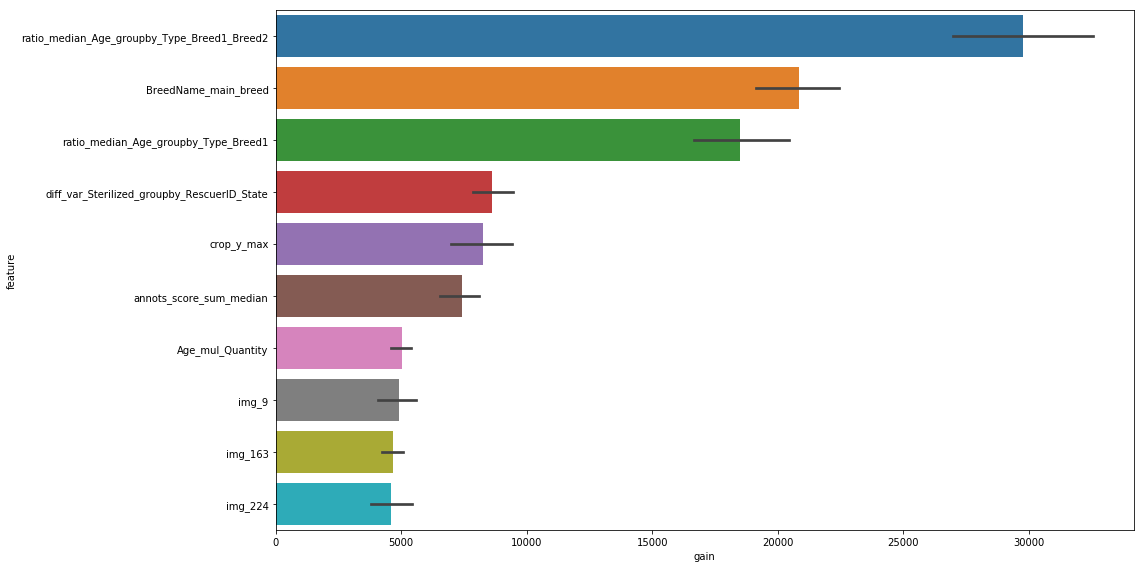

In [135]:
%%time
n_feats =200
predictors = list(data.feature[:n_feats])
categorical_features = list(set(categorical_features) - set(remove))
categorical_features = [c for c in categorical_features if c in predictors]
numerical_features = list(set(predictors) - set(categorical_features + [target] + remove))
#predictors = categorical_features + numerical_features

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
cv = GroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

local(16core)
特徴数-kappa(time)
---
100-0.4605709670182728(31s)
150-0.4630525352163998(38s)
200-0.4627631126511653(46s)
300-0.4614585304106906(59s)
500-0.4609961498746312(1min40s)
1000-0.4498377072144968
all(3784)-0.449078003109212(5min46s)

timeはOptimizedRounderも含む